# Overfitting and Regularization

We have seen some of the core dynamical properties of stochastic gradient descent already. With large, complex problems, frequently the biggest problem is preventing deep models from overfitting. Here we explore 3 important ways to do this.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_circles
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils

Using TensorFlow backend.


## Preventing overfitting with regularization

Below we will do some experiments to detect overfitting and explore some ways to prevent it.

Scikit-learn includes a very small dataset of handwritten digits that we will experiment on.

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()
print digits.data.shape

y = np_utils.to_categorical(digits.target)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y)

(1797, 64)


Take a look at some random digits in the dataset. They are very small images, 8px by 8px.

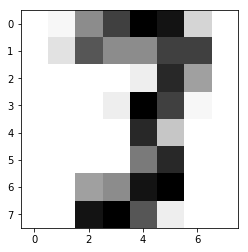

In [5]:
X = digits.data.reshape([len(digits.data), 8, 8])
plt.imshow(X[np.random.randint(len(digits.data))], cmap='Greys')

There are, naturally, 10 classes in this dataset. As a quick check: what is the worst possible accuracy a model can have on this dataset of 10 classes? A: 10%

### Validation data in Keras

Below we create a model with a single hidden layer. We call the `model.fit` method below with the `validation_split` argument. This tells Keras to put aside a portion of the training data as a **validation set**. On every epoch, Keras will compute the loss on the validation set and save it on the history object so that we can inspect it.

In this example, the validation split is set to be 98% of the data! So ony 2% is used for training. Clearly this isn't a good choice, but it does successfully simulate overfitting with a simple example that can train very quickly. Doing experiments like this, even exaggerated ones, is a good way to build intuition.

In [38]:
model0 = Sequential()
model0.add(Dense(32, input_dim=64))
model0.add(Activation('relu'))
model0.add(Dense(10))
model0.add(Activation('softmax'))

sgd = SGD(lr=0.01)
model0.compile(loss='categorical_crossentropy',
               optimizer=sgd,
               metrics=['accuracy'])

history0 = model0.fit(X_train, y_train, nb_epoch=20,
                      batch_size=16, verbose=0,
                      validation_split=0.98)

result = model0.evaluate(X_test, y_test, verbose=0)
print 'Test set loss: ', result[0]
print 'Test set accuracy: ', result[1]

Test set loss:  2.51797271729
Test set accuracy:  0.444444444444


Let's modify our `plot_loss` function to plot the validation loss in red.

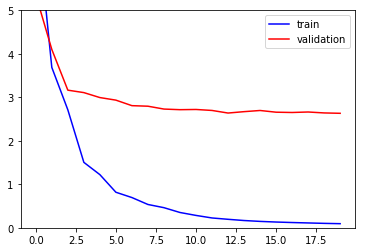

In [39]:
def plot_loss(hist, val=False):
    loss = hist.history['loss']
    val_loss= hist.history['val_loss']
    line1, = plt.plot(range(len(loss)), loss, 'b', label='train')
    line2, = plt.plot(range(len(loss)), val_loss, 'r', label='validation')
    plt.legend(handles=[line1, line2])
    plt.ylim(0,5)
plot_loss(history0, val=True)

This technique of of visualizing the validation loss enables us to see that we are overfitting even very early. The test accuracy is probably very poor.


## 1. More data

The best way to fight overfitting is to provide more data.

- - -
### Exercise 1 - More data

This is an easy one: retrain the model with a reasonable validation split. Does the model still overfit? How can you tell from comparing the plot of this model with the previous plot that the problem is not as bad?

The model is replicated below as `model1`.
- - -

Test set loss:  0.104155361911
Test set accuracy:  0.962222222222


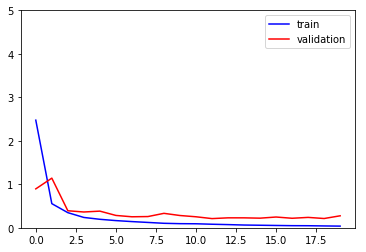

In [40]:
# Add more data by adjusting the validation_split
model1 = Sequential()
model1.add(Dense(32, input_dim=64))
model1.add(Activation('relu'))
model1.add(Dense(10))
model1.add(Activation('softmax'))

sgd = SGD(lr=0.01)
model1.compile(loss='categorical_crossentropy',
               optimizer=sgd,
               metrics=['accuracy'])

history1 = model1.fit(X_train, y_train, nb_epoch=20,
                      batch_size=16, verbose=0,
                      validation_split=0.2) # Adjust the validation split

result = model1.evaluate(X_test, y_test, verbose=0)
print 'Test set loss: ', result[0]
print 'Test set accuracy: ', result[1]

plot_loss(history1, val=True)

## 2. Weight regularization

A very common way to prevent overfitting is to extend the loss function to encourage weights to generally be small. Large weights often mean that the model is "memorizing" the training data. Adding weight regularization is a great way to prevent this.

- - -
### Exercise 2 - Add L2 weight regularization

Let's pretend that we can't simply change the `validation_split`. Add L2 weight regularization to both `Dense` layers in `model2` below. Refer to the [documentation](http://keras.io/regularizers/) to see how to do this.

You will probably need to do a few runs to find a value of the regularization parameter that works well. Can you get the model reliably to get near 60% on the test set?

Note: when you plot that loss, Keras does not include the weight regularization in the validation loss.
- - -

Test set loss:  2.60898087184
Test set accuracy:  0.388888888889


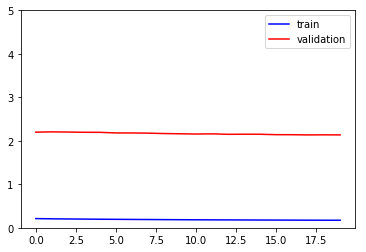

In [45]:
# Add L2 weight regularization
from keras.regularizers import l2

model3 = Sequential()
model3.add(Dense(32, input_dim=64))
model3.add(Activation('relu'))
model3.add(Dense(10, W_regularizer=l2(0.001)))
model3.add(Activation('softmax'))

sgd = SGD(lr=0.01)
model3.compile(loss='categorical_crossentropy',
               optimizer=sgd,
               metrics=['accuracy'])

history3 = model3.fit(X_train, y_train, nb_epoch=20,
                      batch_size=16, verbose=0,
                      validation_split=0.98)

result = model3.evaluate(X_test, y_test, verbose=0)
print 'Test set loss: ', result[0]
print 'Test set accuracy: ', result[1]

plot_loss(history4, val=True)


## 3. Dropout regularization

- - -
### Exercise 3 - Add Dropout

We are using more data and training for longer in the snippet below, but otherwise the model is the same. Run it before modification to see it's behavior.

Refer to the [documentation](http://keras.io/layers/core/#dropout) to add dropout on the hidden layer on the model below.

You should be able to find a dropout parameter that virtually eliminates overfitting as seen in the loss plot. As usually, doing multiple experiments is the best way to build intuition.

Note: In this example, since we are not overfitting particularly badly, you might not see noticeable improvement on the test accuracy. Since dropout zeros out activations, it would take more epoch for each weight to get the same number of gradient updates as without dropout.
- - -

Test set loss:  12.8207698907
Test set accuracy:  0.122222222222


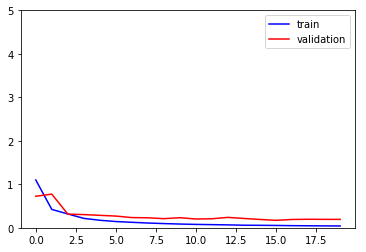

In [48]:
# Add L2 weight regularization
from keras.layers import Dropout

model4 = Sequential()

model4.add(Dense(32, input_dim=64))
model4.add(Activation('relu'))
model4.add(Dropout(0.2))

model4.add(Dense(10))
model4.add(Activation('softmax'))

sgd = SGD(lr=0.01)
model4.compile(loss='categorical_crossentropy',
               optimizer=sgd,
               metrics=['accuracy'])

history4 = model3.fit(X_train, y_train, nb_epoch=20,
                      batch_size=16, verbose=0,
                      validation_split=0.2)

result = model4.evaluate(X_test, y_test, verbose=0)
print 'Test set loss: ', result[0]
print 'Test set accuracy: ', result[1]

plot_loss(history4, val=True)